In [284]:
'''

Joe Shan
Sep 2017

Data and Introduction:
http://www.kdd.org/kdd-cup/view/kdd-cup-1998/Intro

Focus on campaign response

'''

### Initialization

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import TransformerMixin
import pandas_profiling as pprof
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit, probit, poisson, ols


def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()


def profiling_by_decile(X, pred_score):
    import matplotlib.pyplot as plt
    X_col = list(X.columns)
    col = ['decile',]
    col.extend(X_col)
    prof = pd.DataFrame(np.zeros((10,len(col))), columns=col)
    
    centile_point = []
    
    for N in range(10,100,10):
        centile_point.append(np.percentile(pred_score, 100-N))
        
    decile_index =[[s >= centile_point[0] for s in pred_score]
                   ,[centile_point[0] > s >= centile_point[1] for s in pred_score]
                   ,[centile_point[1] > s >= centile_point[2] for s in pred_score]
                   ,[centile_point[2] > s >= centile_point[3] for s in pred_score]
                   ,[centile_point[3] > s >= centile_point[4] for s in pred_score]
                   ,[centile_point[4] > s >= centile_point[5] for s in pred_score]
                   ,[centile_point[5] > s >= centile_point[6] for s in pred_score]
                   ,[centile_point[6] > s >= centile_point[7] for s in pred_score]
                   ,[centile_point[7] > s >= centile_point[8] for s in pred_score]
                   ,[s < centile_point[8] for s in pred_score]]
    
    for i in range(10):
        prof['decile'][i] = i+1
        for j in range(1,len(col)):
            prof[col[j]][i] = X[col[j]][decile_index[i]].mean()
    
    prof['decile'] = prof['decile'].astype(int)
    
    for j in range(1,len(col)):
        plt.bar(prof['decile'], prof[col[j]])
        plt.ylabel('Mean of %s' % col[j])
        plt.xlabel('decile')
        plt.title('Profile of %s by decile' % col[j])
        plt.show()
    
    return prof


def performance_by_decile(y, pred_score):
    perf = pd.DataFrame(np.zeros((10,6)),columns=['decile','size','resp', 'resp %','cum. resp', 'cum. resp %'])
    obs_num = len(y)
    resp_num = y.sum()

    centile_point = []
    
    for N in range(10,100,10):
        centile_point.append(np.percentile(pred_score, 100-N))
        
     
    decile_index =[[s >= centile_point[0] for s in pred_score]
                   ,[centile_point[0] > s >= centile_point[1] for s in pred_score]
                   ,[centile_point[1] > s >= centile_point[2] for s in pred_score]
                   ,[centile_point[2] > s >= centile_point[3] for s in pred_score]
                   ,[centile_point[3] > s >= centile_point[4] for s in pred_score]
                   ,[centile_point[4] > s >= centile_point[5] for s in pred_score]
                   ,[centile_point[5] > s >= centile_point[6] for s in pred_score]
                   ,[centile_point[6] > s >= centile_point[7] for s in pred_score]
                   ,[centile_point[7] > s >= centile_point[8] for s in pred_score]
                   ,[s < centile_point[8] for s in pred_score]]
    
    for i in range(10):
        perf['decile'][i] = i+1
        perf['size'][i] = len(y[decile_index[i]])
        perf['resp'][i] = y[decile_index[i]].sum()
        perf['resp %'][i] = round(perf['resp'][i]/resp_num*100,2)
        perf['cum. resp'][i] = perf['resp'][0:i+1].sum()
        perf['cum. resp %'][i] = round(perf['cum. resp'][i]/resp_num*100,2)
        
    perf[['decile','size','resp','cum. resp']] = perf[['decile','size','resp','cum. resp']].astype(int)
    
    return perf
    
    
def vif_cal(input_data):
    import statsmodels.formula.api as sm
    x_vars=input_data
    xvar_names=input_data.columns
    vif_lst=[]
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_lst.append(vif)  
    vif_df = pd.concat([pd.DataFrame(xvar_names,columns=['Variable']),pd.DataFrame(vif_lst,columns=['VIF'])],axis=1)
    return vif_df
        

def auto_countplot(data_df, y_name):
    sns.set_style('whitegrid')
    for var in data_df.columns.drop(y_name):
        sns.countplot(x = y_name , hue = var, data = data_df, palette='RdBu_r')
        plt.show()
        print('\n')
        print(data_df.groupby([var, y_name]).count())
        print('\n')
        

class Missing_Imputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    

def check_non_num(X_col, X):
    for c in X_col:
        if X[c].dtype == np.dtype('O'):
            print(c,' is still object dtype!')


def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    import numpy as np
    from scipy import stats, linalg
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

In [2]:
### read-in model data
inputfile = '/Users/joeshan/Documents/Python models/cup98/cup98LRN.txt'
data = pd.read_csv(inputfile,header=0,dtype={"DOB": int}) 
data.head() # check read-in data

### read-in validation data
inputfile_v = '/Users/joeshan/Documents/Python models/cup98/cup98VAL.txt'
data_v = pd.read_csv(inputfile_v,header=0,dtype={"DOB": int}) 
data_v.head() # check read-in data

print(data.shape)
print(data_v.shape)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(95412, 481)
(96367, 479)


In [3]:
data.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,,,5202,0,,...,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,,,0,0,,...,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,,,2801,0,,...,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,,0,FL,33176,,,2001,0,X,...,0.0,1,L,2,F,X,X,X,26.0,A


In [4]:
data_v.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,9301,PV3,0,WI,53558,,,1702,0,X,...,188946,1,L,1,G,X,X,X,15.0,B
1,9501,CNT,0,TX,78501,,,1501,0,,...,126296,1,L,1,F,X,X,X,13.0,B
2,9101,L01,1,CA,92392,,,3001,0,,...,155244,1,L,1,G,X,X,X,34.0,A
3,9401,HAM,0,TX,77625-,,,4909,0,,...,123985,0,L,1,F,X,X,X,58.0,B
4,9201,NAS,2,TX,76051,,,5406,0,,...,119118,1,L,3,E,X,X,X,2.0,A


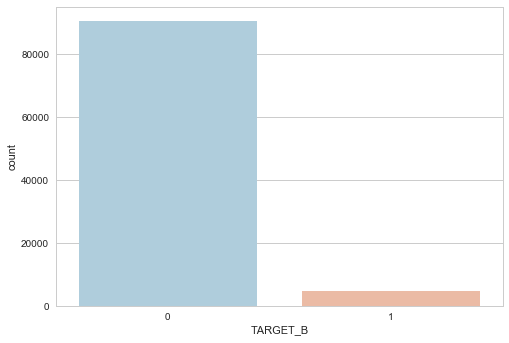

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [5]:
### dependent variable distribution
sns.set_style('whitegrid')
sns.countplot(x='TARGET_B',data=data,palette='RdBu_r')
plt.show()

data['TARGET_B'].value_counts()
#data.groupby('TARGET_B').count()

Current size: [8.0, 5.5]


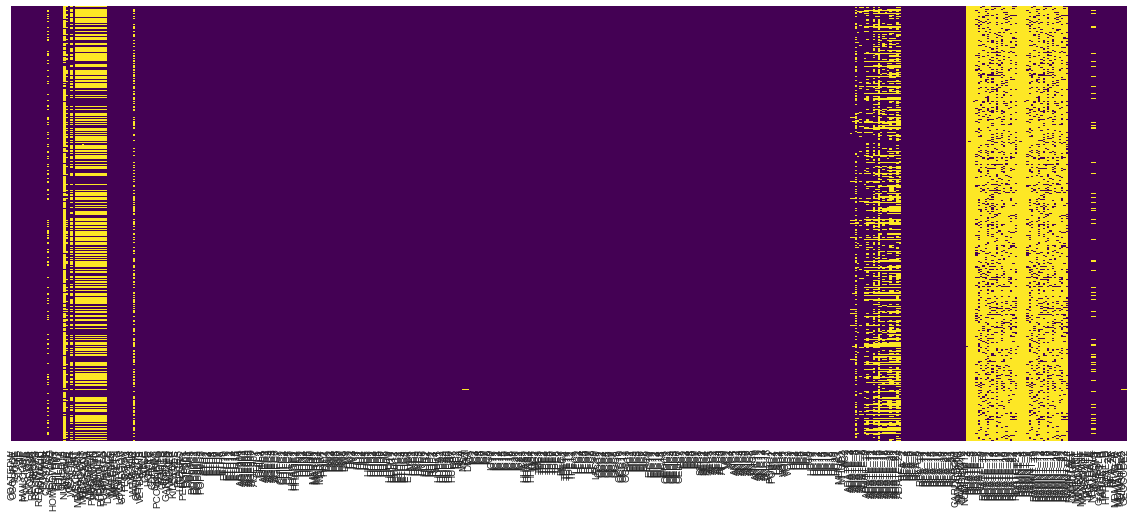

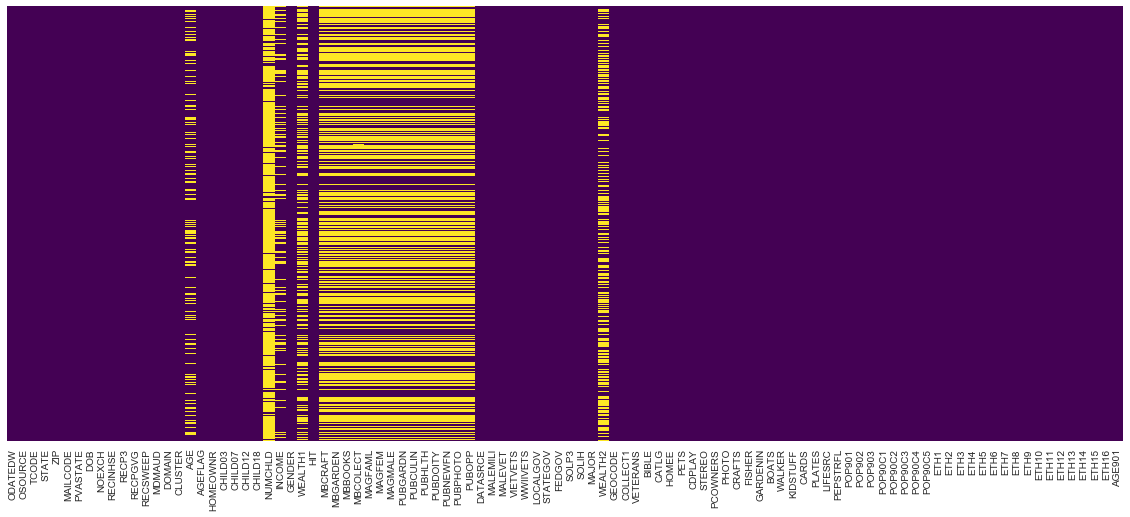

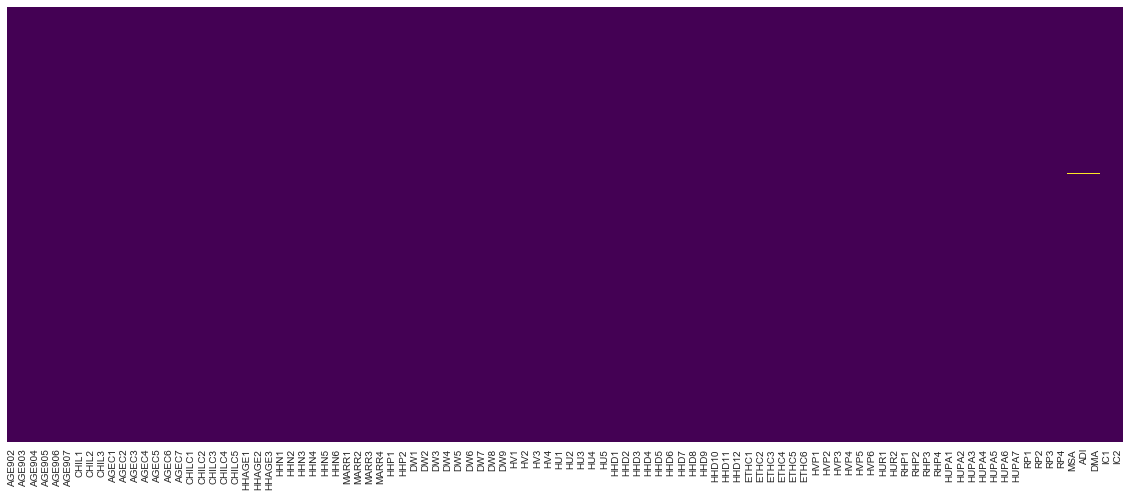

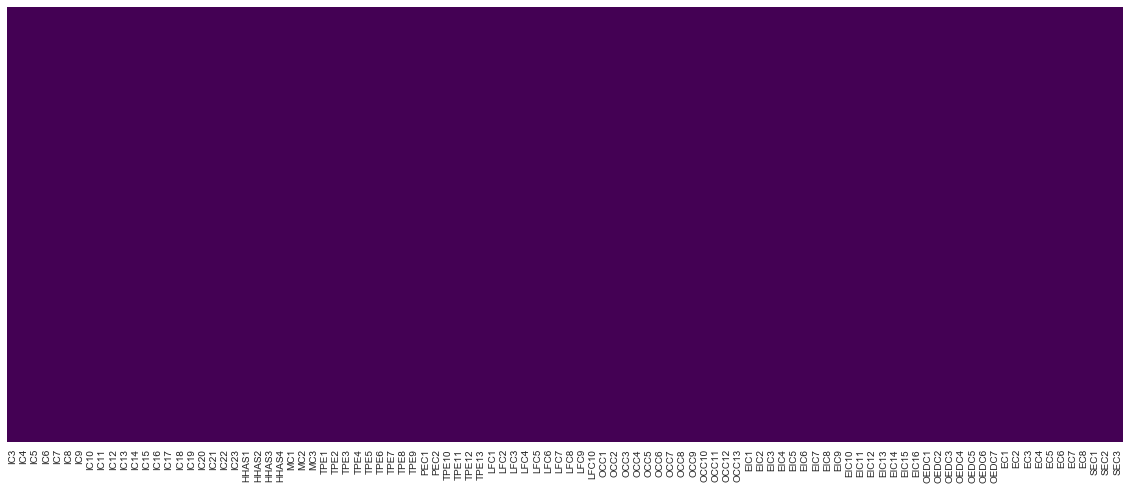

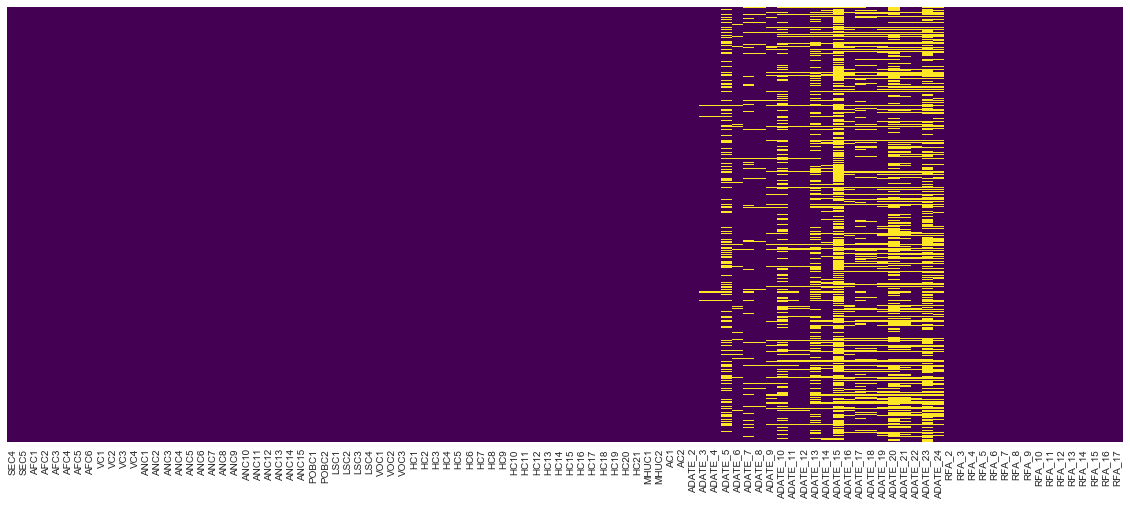

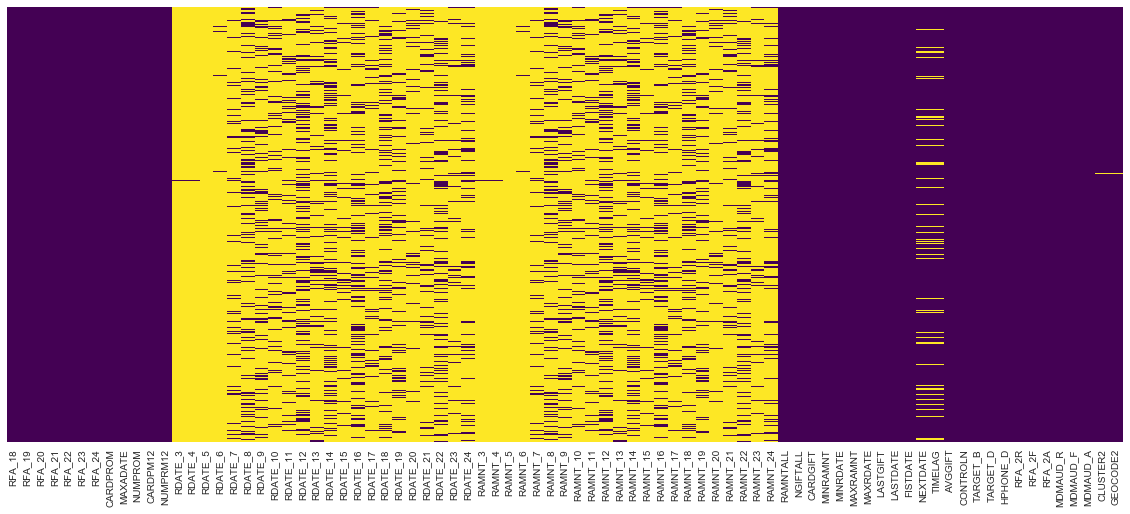

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
count,95412.000000,95412,95412.000000,95412,95412,95412,95412,95412.000000,95412,95412,...,95412.000000,95412.000000,95412,95412.000000,95412,95412,95412,95412,95280.000000,95280
unique,NaN,896,NaN,57,19938,2,3,NaN,6,2,...,NaN,NaN,1,NaN,4,5,4,5,NaN,5
top,NaN,MBC,NaN,CA,85351,,,NaN,0,,...,NaN,NaN,L,NaN,F,X,X,X,NaN,A
freq,NaN,4539,NaN,17343,61,94013,93954,NaN,61203,88709,...,NaN,NaN,95412,NaN,46964,95118,95118,95118,NaN,34484
mean,9141.363256,NaN,54.223117,NaN,NaN,NaN,NaN,2723.602933,NaN,NaN,...,0.793073,0.500618,NaN,1.910053,NaN,NaN,NaN,NaN,31.533711,NaN
std,343.454752,NaN,953.844476,NaN,NaN,NaN,NaN,2132.241295,NaN,NaN,...,4.429725,0.500002,NaN,1.072749,NaN,NaN,NaN,NaN,18.764614,NaN
min,8306.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN
25%,8801.000000,NaN,0.000000,NaN,NaN,NaN,NaN,201.000000,NaN,NaN,...,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,15.000000,NaN
50%,9201.000000,NaN,1.000000,NaN,NaN,NaN,NaN,2610.000000,NaN,NaN,...,0.000000,1.000000,NaN,2.000000,NaN,NaN,NaN,NaN,32.000000,NaN
75%,9501.000000,NaN,2.000000,NaN,NaN,NaN,NaN,4601.000000,NaN,NaN,...,0.000000,1.000000,NaN,3.000000,NaN,NaN,NaN,NaN,49.000000,NaN


In [6]:

### check missing values
"""
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()
"""

### Get current size
fig_size = plt.rcParams["figure.figsize"]
print('Current size:', fig_size)
 
### Set figure width and height
fig_width = 20 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

### check missing values
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[0:100]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[100:200]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[200:300]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[300:400]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[400:482]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

data.describe(include='all')

In [7]:
### split train set and test set

# setup dependent var
y_col = 'TARGET_B' ### change every time

X_train, X_test, y_train, y_test = train_test_split(data.drop(y_col, 1), data[y_col]
                                                    , train_size=0.8, random_state=879)

print('X_train size: %s' % str(X_train.shape))
print('y_train size: %s' % str(y_train.shape))

print('X_test size: %s' % str(X_test.shape))
print('y_test size: %s' % str(y_test.shape))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


X_train size: (76329, 480)
y_train size: (76329,)
X_test size: (19083, 480)
y_test size: (19083,)


Before recoding, table shape: (76329, 480)
After imputation, table shape: (76329, 379)


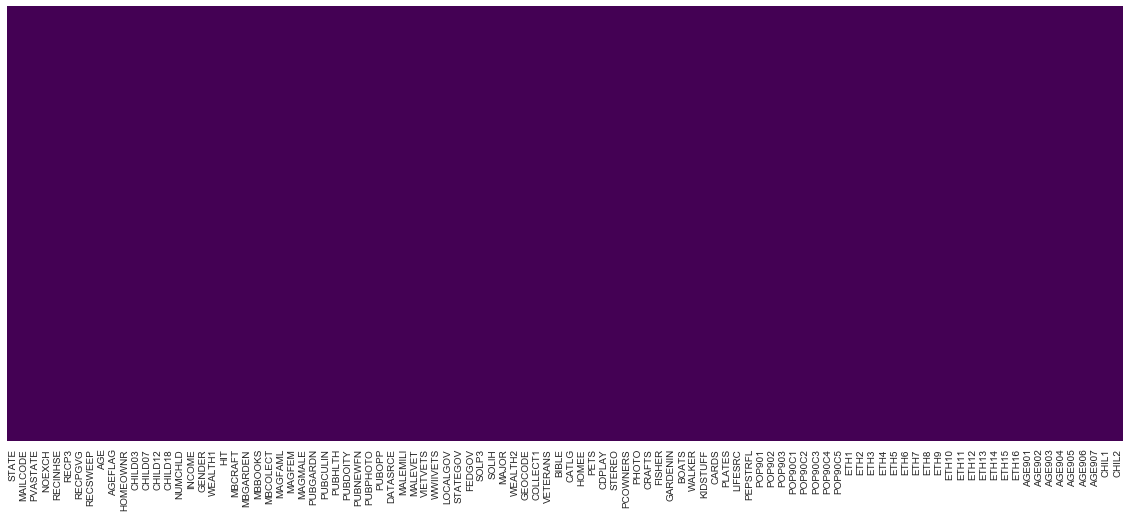

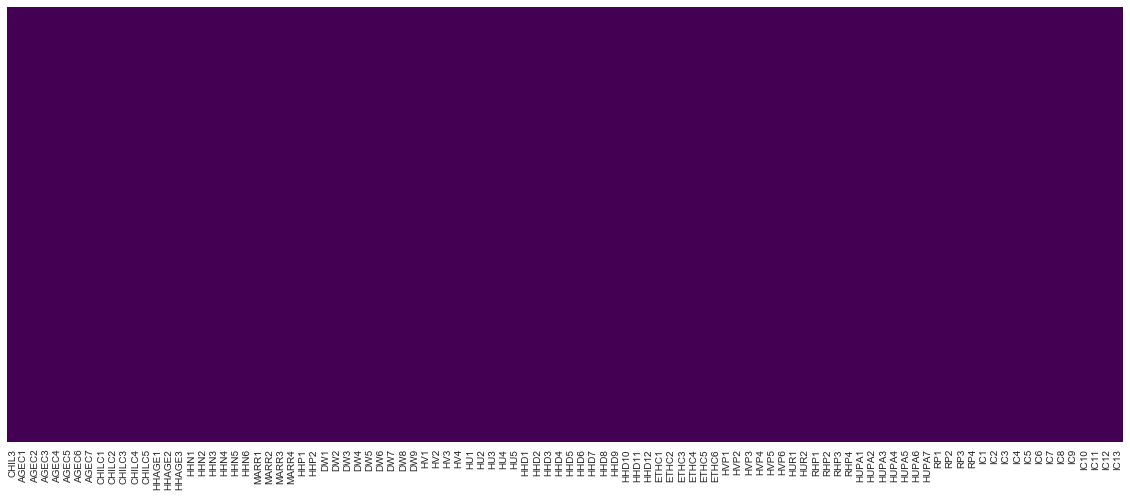

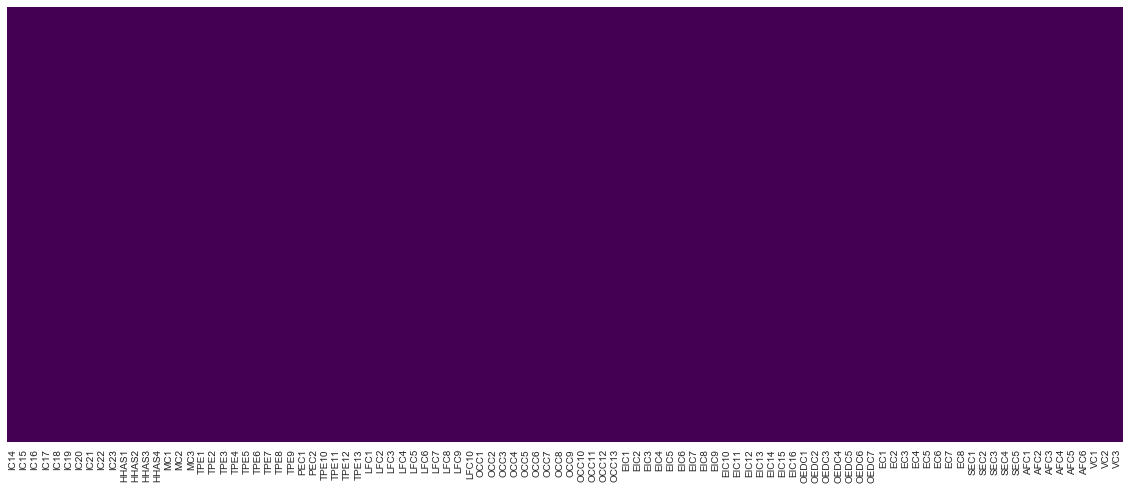

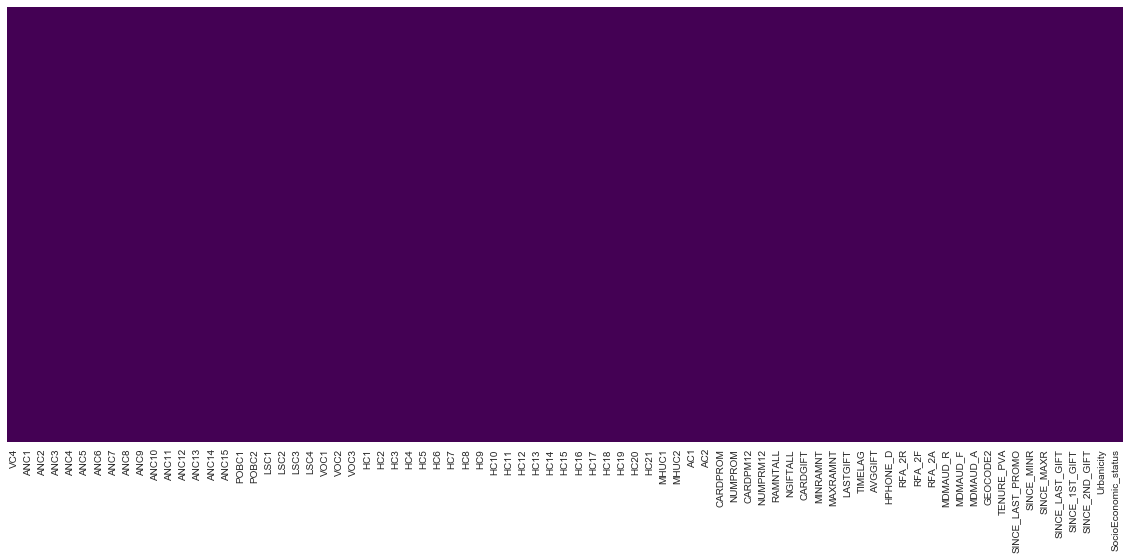

Afer recoding, table shape: (76329, 472)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76329 entries, 82091 to 35963
Columns: 472 entries, MAILCODE to GEOCODE2_D
dtypes: float64(26), int64(342), uint8(104)
memory usage: 222.5 MB


,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,AGE,AGEFLAG,HOMEOWNR,...,GEOCODE_04,GEOCODE_05,GEOCODE_12,GEOCODE_14,RFA_2R_L,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
82091,0,0,0,0,0,0,0,83.0,1,1,...,0,0,0,0,1,0,0,1,0,0
90744,0,0,0,0,0,0,0,62.0,0,0,...,0,0,1,0,1,0,0,0,0,1
11812,0,0,0,0,0,0,0,70.0,1,1,...,0,0,0,0,1,0,0,1,0,0
35386,0,0,0,0,0,0,0,62.0,0,1,...,0,0,0,0,1,0,0,0,1,0
59386,0,0,0,0,0,0,0,61.0,1,1,...,0,0,0,0,1,0,0,1,0,0


In [8]:
### recording

### recode the train set

input_data = X_train.copy()

var_drop_list = ['ODATEDW', 'TCODE','OSOURCE','ZIP','DOB','CLUSTER','MDMAUD','TARGET_D','CONTROLN',
                 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9',
                 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17',
                 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24',
                 'RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12',
                 'RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22',
                 'RFA_23','RFA_24','MAXADATE','RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8',
                 'RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16',
                 'RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24',
                 'RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11',
                 'RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20',
                 'RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24','MINRDATE','MAXRDATE','LASTDATE','NEXTDATE','FISTDATE',
                 'CLUSTER2','DOMAIN','MSA','ADI','DMA'
                ]

# drop some variables

data_output = input_data.drop(labels = var_drop_list, axis=1)

# convert some flags

def rec_flags(value):
    if value in ['X','B','Y','E','H']:
        return 1
    else:
        return 0


var_flag_list = ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP',
                 'AGEFLAG','HOMEOWNR','MAJOR','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS',
                 'CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                 'KIDSTUFF','CARDS','PLATES','PEPSTRFL']

for var_raw in var_flag_list:
    data_output[var_raw] = input_data[var_raw].apply(rec_flags)


# fill some missings

input_data['AGE'] = input_data['AGE'].replace(0, None)
input_data['DOMAIN'] = input_data['DOMAIN'].replace(' ', None) 
input_data['SOLP3'] = input_data['SOLP3'].replace(' ', '15')
input_data['SOLIH'] = input_data['SOLIH'].replace(' ', '15')
input_data['LIFESRC'] = input_data['LIFESRC'].replace(' ', '0')
input_data['DATASRCE'] = input_data['DATASRCE'].replace(' ', '0')
input_data['GENDER'] = input_data['GENDER'].replace('U', None)
input_data['GENDER'] = input_data['GENDER'].replace('J', None)
input_data['GENDER'] = input_data['GENDER'].replace('C', None)
input_data['GENDER'] = input_data['GENDER'].replace('A', None)

for var in ['ODATEDW','MAXADATE','MINRDATE','MAXRDATE','LASTDATE','FISTDATE','NEXTDATE']:
    input_data[var] = input_data[var].replace(0, None)

# covert date to month_diff

def month_cal(YYMM):
    return int(str(YYMM)[0:2])*12 + int(str(YYMM)[2:4])

def month_diff(input_month, month_to_compare = 9807):
    if input_month is None or np.isnan(input_month):
        return None
    else:
        return month_cal(month_to_compare) - month_cal(input_month)


data_output['TENURE_PVA'] = input_data['ODATEDW'].apply(month_diff)
data_output['SINCE_LAST_PROMO'] = input_data['MAXADATE'].apply(month_diff)
data_output['SINCE_MINR'] = input_data['MINRDATE'].apply(month_diff)
data_output['SINCE_MAXR'] = input_data['MAXRDATE'].apply(month_diff)
data_output['SINCE_LAST_GIFT'] = input_data['LASTDATE'].apply(month_diff)
data_output['SINCE_1ST_GIFT'] = input_data['FISTDATE'].apply(month_diff)
data_output['SINCE_2ND_GIFT'] = input_data['NEXTDATE'].apply(month_diff)

# define some ordered variables

amount_dict = {'L':0, 'C':1, 'M':2, 'T':'3', 'X':0}
frequency_dict = {'1':1,'2':2,'3':3,'4':4,'5':5,'X':0}
amount2_dict = {'A':0, 'B':1, 'C':2, 'D':'3','E':'4','F':'5','G':'6','X':0}

data_output['Urbanicity'] = input_data['DOMAIN'].apply(lambda x: x[0])
data_output['SocioEconomic_status'] = input_data['DOMAIN'].apply(lambda x: int(x[1]))

data_output['SOLP3'] = input_data['SOLP3'].apply(int)
data_output['SOLIH'] = input_data['SOLIH'].apply(int)
data_output['LIFESRC'] = input_data['LIFESRC'].apply(int)

data_output['RFA_2F'] = input_data['RFA_2F'].apply(lambda x: frequency_dict[str(x)])
data_output['RFA_2A'] = input_data['RFA_2A'].apply(lambda x: amount2_dict[x]).astype(int)

data_output['MDMAUD_F'] = input_data['MDMAUD_F'].apply(lambda x: frequency_dict[x])
data_output['MDMAUD_A'] = input_data['MDMAUD_A'].apply(lambda x: amount_dict[x]).astype(int)

data_output['DATASRCE'] = input_data['DATASRCE'].astype(int)

# adjust nominal variable dtype
var_cate_list = ['MDMAUD_R','Urbanicity','CHILD03','CHILD07','CHILD12', 'CHILD18', 'GENDER', 'STATE',
                 'GEOCODE','RFA_2R','GEOCODE2'
                ]

data_output[var_cate_list] = data_output[var_cate_list].astype(object)

# Imputation of missing values. freq for nominal, median for numeric

missing_recode = Missing_Imputer()
missing_recode.fit(data_output)
data_output = missing_recode.transform(data_output)

# new heatmaps after Imputation
print('Before recoding, table shape:',input_data.shape)
print('After imputation, table shape:',data_output.shape)

### Set figure width and height
fig_width = 20 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

sns.heatmap(data_output[data_output.columns[0:100]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[100:200]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[200:300]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[300:383]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

# Encoding categorical features
'''
Right now, OneHotEncoder only support numeric variables.
Example:
OneHotEncoder(sparse = False).fit_transform( testdata[['age']] )

For string, there are two commmon ways.

1) Apply LabelEncoder() to convert strings into numbers, then apply OneHotEncoder().
Example:
testdata = pd.DataFrame({'pet': ['cat', 'dog', 'dog', 'fish', None, None],                         
'age': [4 , 6, 3, 3, None, None],                         
'salary':[4, 5, 1, 1, None, None]})
a = LabelEncoder().fit_transform(testdata['pet'])
OneHotEncoder( sparse=False ).fit_transform(a.reshape(-1,1))

2) Apply LabelBinarizer() directly. Note: LabelBinarizer() only accepts 1-D array.
Example:
LabelBinarizer().fit_transform(testdata['pet'])

3) Apply pd.get_dummies() in pandas
Example:
pd.get_dummies(testdata['pet'])

Before when OneHotEncoder() supports string, I use pd.get_dummies().
'''
# create dummy variables

data_output = pd.concat([data_output.drop(labels = var_cate_list, axis=1)
                         ,pd.get_dummies(data_output[var_cate_list])], axis=1)

# check the dimensions

print('Afer recoding, table shape:',data_output.shape)

train_set = data_output.copy()
train_set.info()
train_set.head()

Before recoding, table shape: (19083, 480)
After imputation, table shape: (19083, 379)


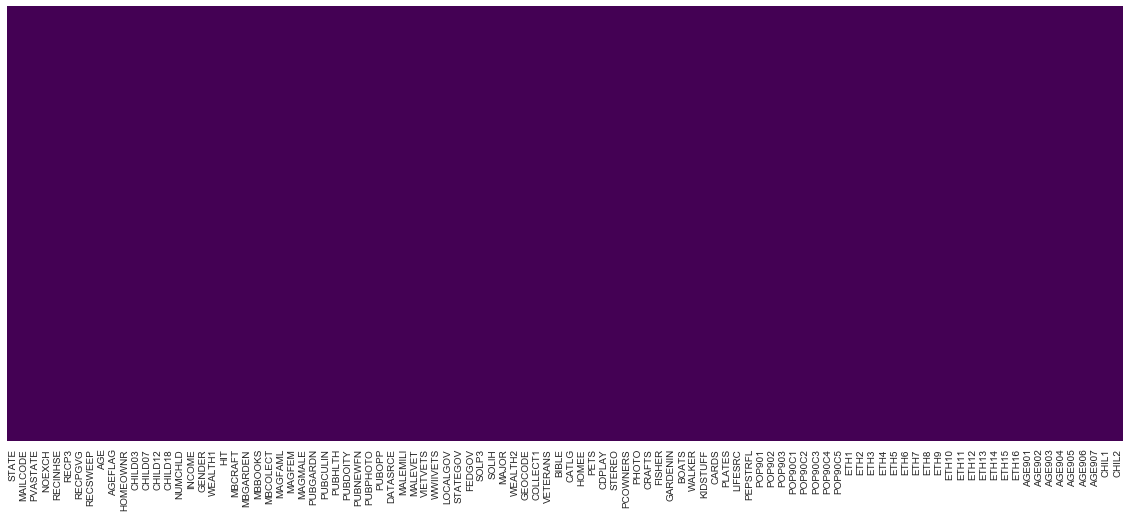

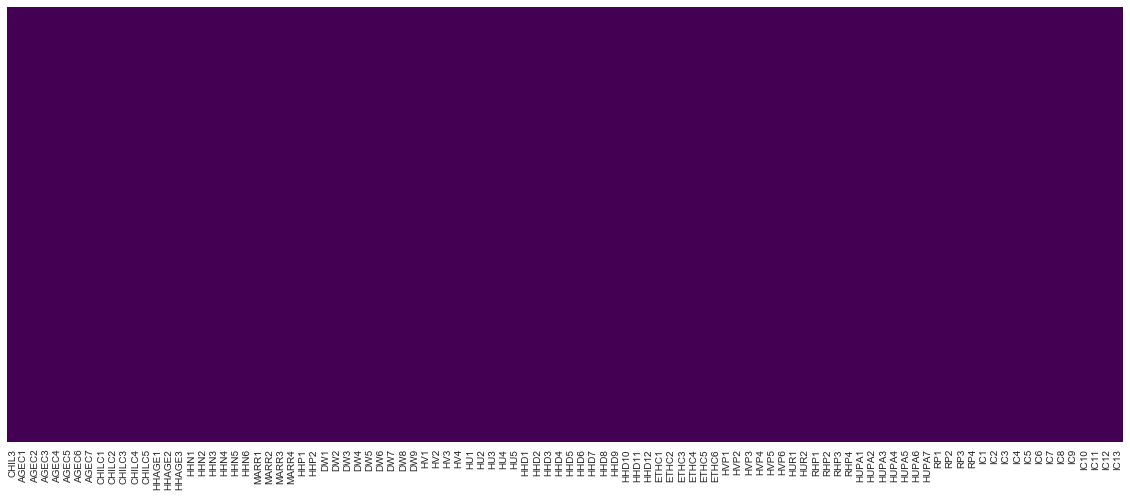

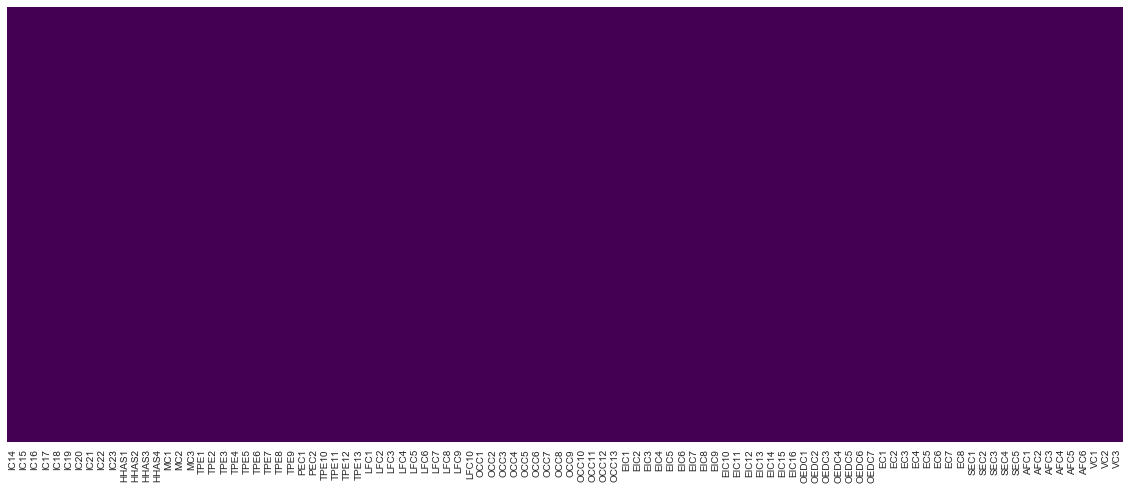

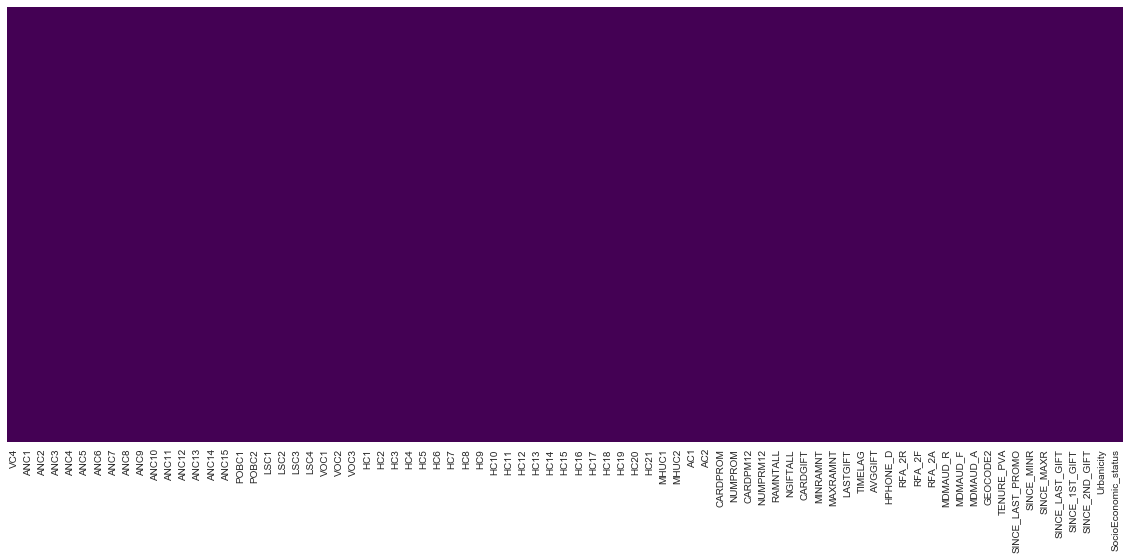

Afer recoding, table shape: (19083, 467)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19083 entries, 78865 to 15610
Columns: 467 entries, MAILCODE to GEOCODE2_D
dtypes: float64(26), int64(342), uint8(99)
memory usage: 55.5 MB


,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,AGE,AGEFLAG,HOMEOWNR,...,GEOCODE_04,GEOCODE_05,GEOCODE_12,GEOCODE_14,RFA_2R_L,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
78865,0,0,0,0,0,0,0,70.0,0,0,...,0,0,1,0,1,0,1,0,0,0
47928,0,0,0,0,0,0,0,51.0,0,0,...,0,0,0,0,1,0,1,0,0,0
15217,0,0,0,1,0,0,0,38.0,0,1,...,0,0,0,0,1,0,0,0,0,1
34277,0,0,0,0,0,0,0,62.0,1,0,...,0,0,0,0,1,0,0,1,0,0
36563,0,0,0,0,0,0,0,73.0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [9]:
# recode test set

input_data = X_test.copy()

var_drop_list = ['ODATEDW', 'TCODE','OSOURCE','ZIP','DOB','CLUSTER','MDMAUD','TARGET_D','CONTROLN',
                 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9',
                 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17',
                 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24',
                 'RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12',
                 'RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22',
                 'RFA_23','RFA_24','MAXADATE','RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8',
                 'RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16',
                 'RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24',
                 'RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11',
                 'RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20',
                 'RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24','MINRDATE','MAXRDATE','LASTDATE','NEXTDATE','FISTDATE',
                 'CLUSTER2','DOMAIN','MSA','ADI','DMA'
                ]


# drop some variables

data_output = input_data.drop(labels = var_drop_list, axis=1)

# convert some flags

def rec_flags(value):
    if value in ['X','B','Y','E','H']:
        return 1
    else:
        return 0


var_flag_list = ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP',
                 'AGEFLAG','HOMEOWNR','MAJOR','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS',
                 'CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                 'KIDSTUFF','CARDS','PLATES','PEPSTRFL'
                ]

for var_raw in var_flag_list:
    data_output[var_raw] = input_data[var_raw].apply(rec_flags)


# fill some missings

input_data['AGE'] = input_data['AGE'].replace(0, None)
input_data['DOMAIN'] = input_data['DOMAIN'].replace(' ', None) 
input_data['SOLP3'] = input_data['SOLP3'].replace(' ', '15')
input_data['SOLIH'] = input_data['SOLIH'].replace(' ', '15')
input_data['LIFESRC'] = input_data['LIFESRC'].replace(' ', '0')
input_data['DATASRCE'] = input_data['DATASRCE'].replace(' ', '0')
input_data['GENDER'] = input_data['GENDER'].replace('U', None)
input_data['GENDER'] = input_data['GENDER'].replace('J', None)
input_data['GENDER'] = input_data['GENDER'].replace('C', None)
input_data['GENDER'] = input_data['GENDER'].replace('A', None)


for var in ['ODATEDW','MAXADATE','MINRDATE','MAXRDATE','LASTDATE','FISTDATE','NEXTDATE']:
    input_data[var] = input_data[var].replace(0, None)

# covert date to month_diff

def month_cal(YYMM):
    return int(str(YYMM)[0:2])*12 + int(str(YYMM)[2:4])

def month_diff(input_month, month_to_compare = 9807):
    if input_month is None or np.isnan(input_month):
        return None
    else:
        return month_cal(month_to_compare) - month_cal(input_month)


data_output['TENURE_PVA'] = input_data['ODATEDW'].apply(month_diff)
data_output['SINCE_LAST_PROMO'] = input_data['MAXADATE'].apply(month_diff)
data_output['SINCE_MINR'] = input_data['MINRDATE'].apply(month_diff)
data_output['SINCE_MAXR'] = input_data['MAXRDATE'].apply(month_diff)
data_output['SINCE_LAST_GIFT'] = input_data['LASTDATE'].apply(month_diff)
data_output['SINCE_1ST_GIFT'] = input_data['FISTDATE'].apply(month_diff)
data_output['SINCE_2ND_GIFT'] = input_data['NEXTDATE'].apply(month_diff)

# define some ordered variables

amount_dict = {'L':0, 'C':1, 'M':2, 'T':'3', 'X':0}
frequency_dict = {'1':1,'2':2,'3':3,'4':4,'5':5,'X':0}
amount2_dict = {'A':0, 'B':1, 'C':2, 'D':'3','E':'4','F':'5','G':'6','X':0}

data_output['Urbanicity'] = input_data['DOMAIN'].apply(lambda x: x[0])
data_output['SocioEconomic_status'] = input_data['DOMAIN'].apply(lambda x: int(x[1]))

data_output['SOLP3'] = input_data['SOLP3'].apply(int)
data_output['SOLIH'] = input_data['SOLIH'].apply(int)
data_output['LIFESRC'] = input_data['LIFESRC'].apply(int)

data_output['RFA_2F'] = input_data['RFA_2F'].apply(lambda x: frequency_dict[str(x)])
data_output['RFA_2A'] = input_data['RFA_2A'].apply(lambda x: amount2_dict[x]).astype(int)

data_output['MDMAUD_F'] = input_data['MDMAUD_F'].apply(lambda x: frequency_dict[x])
data_output['MDMAUD_A'] = input_data['MDMAUD_A'].apply(lambda x: amount_dict[x]).astype(int)

data_output['DATASRCE'] = input_data['DATASRCE'].astype(int)

# adjust nominal variable dtype
var_cate_list = ['MDMAUD_R','Urbanicity','CHILD03','CHILD07','CHILD12', 'CHILD18', 'GENDER', 'STATE',
                 'GEOCODE','RFA_2R','GEOCODE2'
                ]

data_output[var_cate_list] = data_output[var_cate_list].astype(object)

# Imputation of missing values. freq for nominal, median for numeric
#missing_recode = Missing_Imputer()
#missing_recode.fit(data_output)
data_output = missing_recode.transform(data_output)

# new heatmaps after Imputation
print('Before recoding, table shape:',input_data.shape)
print('After imputation, table shape:',data_output.shape)

### Set figure width and height
fig_width = 20 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

sns.heatmap(data_output[data_output.columns[0:100]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[100:200]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[200:300]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[300:383]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

# Encoding categorical features
'''
Right now, OneHotEncoder only support numeric variables.
Example:
OneHotEncoder(sparse = False).fit_transform( testdata[['age']] )

For string, there are two commmon ways.

1) Apply LabelEncoder() to convert strings into numbers, then apply OneHotEncoder().
Example:
testdata = pd.DataFrame({'pet': ['cat', 'dog', 'dog', 'fish', None, None],                         
'age': [4 , 6, 3, 3, None, None],                         
'salary':[4, 5, 1, 1, None, None]})
a = LabelEncoder().fit_transform(testdata['pet'])
OneHotEncoder( sparse=False ).fit_transform(a.reshape(-1,1))

2) Apply LabelBinarizer() directly. Note: LabelBinarizer() only accepts 1-D array.
Example:
LabelBinarizer().fit_transform(testdata['pet'])

3) Apply pd.get_dummies() in pandas
Example:
pd.get_dummies(testdata['pet'])

Before when OneHotEncoder() supports string, I use pd.get_dummies().
'''
# create dummy variables

data_output = pd.concat([data_output.drop(labels = var_cate_list, axis=1)
                         ,pd.get_dummies(data_output[var_cate_list])], axis=1)

# check the dimensions

print('Afer recoding, table shape:',data_output.shape)

test_set = data_output.copy()
test_set.info()
test_set.head()

In [10]:
# setup independent var

X_col0 = list(train_set.columns)
#print(X_col0)

for i in train_set.columns:
    if i not in list(X_test.columns):
        print(i,' is not in the test set')
        X_col0.remove(i)

print('\nVariables included:')
X_col = []
for val in X_col0:
    if val not in ['TARGET_B', 'POP902']:
        X_col.append(val) ### remove some variables to tune the model, start from the dependent variable

      
print('\n')
print(X_col)
print(y_col)
print('\n')

X_train = train_set[X_col] ### set of independent variables
X_test = test_set[X_col]

# check if all variables are numeric

check_non_num(X_col, X_train)
            
# variable standardization for variable selection

std_scaler = preprocessing.StandardScaler()
std_scaler.fit(X_train)

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)

#X_standardized_train = pd.DataFrame(min_max_scaler.transform(X_train), columns=X_col)
X_standardized_train = pd.DataFrame(std_scaler.transform(X_train), columns=X_col)

print('X_standardized_train size: %s' % str(X_standardized_train.shape))

X_standardized_train.describe(include='all')


TENURE_PVA  is not in the test set
SINCE_LAST_PROMO  is not in the test set
SINCE_MINR  is not in the test set
SINCE_MAXR  is not in the test set
SINCE_LAST_GIFT  is not in the test set
SINCE_1ST_GIFT  is not in the test set
SINCE_2ND_GIFT  is not in the test set
SocioEconomic_status  is not in the test set
MDMAUD_R_C  is not in the test set
MDMAUD_R_D  is not in the test set
MDMAUD_R_I  is not in the test set
MDMAUD_R_L  is not in the test set
MDMAUD_R_X  is not in the test set
Urbanicity_C  is not in the test set
Urbanicity_R  is not in the test set
Urbanicity_S  is not in the test set
Urbanicity_T  is not in the test set
Urbanicity_U  is not in the test set
CHILD03_   is not in the test set
CHILD03_B  is not in the test set
CHILD03_F  is not in the test set
CHILD03_M  is not in the test set
CHILD07_   is not in the test set
CHILD07_B  is not in the test set
CHILD07_F  is not in the test set
CHILD07_M  is not in the test set
CHILD12_   is not in the test set
CHILD12_B  is not in the 

,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,AGE,AGEFLAG,HOMEOWNR,...,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,HPHONE_D,RFA_2F,RFA_2A,MDMAUD_F,MDMAUD_A
count,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,...,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04,7.632900e+04
mean,-1.768151e-15,-2.566101e-15,4.423688e-15,3.689400e-15,-1.697453e-15,1.015026e-16,1.634105e-15,1.064298e-15,-1.197297e-15,4.150860e-16,...,1.745355e-15,-8.038321e-16,3.536440e-16,-2.311294e-15,-2.871229e-18,1.534249e-15,1.718912e-16,1.518127e-15,-1.388326e-15,-1.568227e-15
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-1.219768e-01,-8.093837e-03,-1.949561e-02,-2.748474e-01,-1.472553e-01,-3.511452e-02,-1.318365e-01,-4.203372e+00,-1.228618e+00,-1.101397e+00,...,-9.465803e-01,-5.613139e-01,-1.255784e+00,-1.276664e+00,-1.134923e+00,-1.000799e+00,-8.489846e-01,-2.162970e+00,-4.689886e-02,-5.122784e-02
25%,-1.219768e-01,-8.093837e-03,-1.949561e-02,-2.748474e-01,-1.472553e-01,-3.511452e-02,-1.318365e-01,-6.721160e-01,-1.228618e+00,-1.101397e+00,...,-5.879290e-01,-2.248290e-01,-5.296388e-01,-6.253678e-01,-4.676305e-01,-1.000799e+00,-8.489846e-01,-9.749116e-01,-4.689886e-02,-5.122784e-02
50%,-1.219768e-01,-8.093837e-03,-1.949561e-02,-2.748474e-01,-1.472553e-01,-3.511452e-02,-1.318365e-01,2.028705e-02,8.139228e-01,9.079375e-01,...,-3.488281e-01,-1.126674e-01,-1.665663e-01,-2.997194e-01,-1.617181e-01,9.992011e-01,8.323259e-02,2.131466e-01,-4.689886e-02,-5.122784e-02
75%,-1.219768e-01,-8.093837e-03,-1.949561e-02,-2.748474e-01,-1.472553e-01,-3.511452e-02,-1.318365e-01,6.434498e-01,8.139228e-01,9.079375e-01,...,2.489242e-01,1.116558e-01,1.965061e-01,3.515772e-01,2.030236e-01,9.992011e-01,1.015450e+00,2.131466e-01,-4.689886e-02,-5.122784e-02
max,8.198280e+00,1.235508e+02,5.129361e+01,3.638383e+00,6.790925e+00,2.847825e+01,7.585151e+00,2.512938e+00,8.139228e-01,9.079375e-01,...,5.882864e+01,1.861878e+02,7.135871e+01,7.069162e+01,8.802341e+01,9.992011e-01,1.947667e+00,1.401205e+00,4.705498e+01,4.802463e+01


In [11]:
### variable reduction

# specify the model
estimator = linear_model.LogisticRegression(class_weight='balanced')    # estimator for RFE, select the suitable model 

# select variables using RFECV
selector = RFECV(estimator, step=1, cv=3, n_jobs=-1, scoring='roc_auc')
selector = selector.fit(X_standardized_train, y_train)


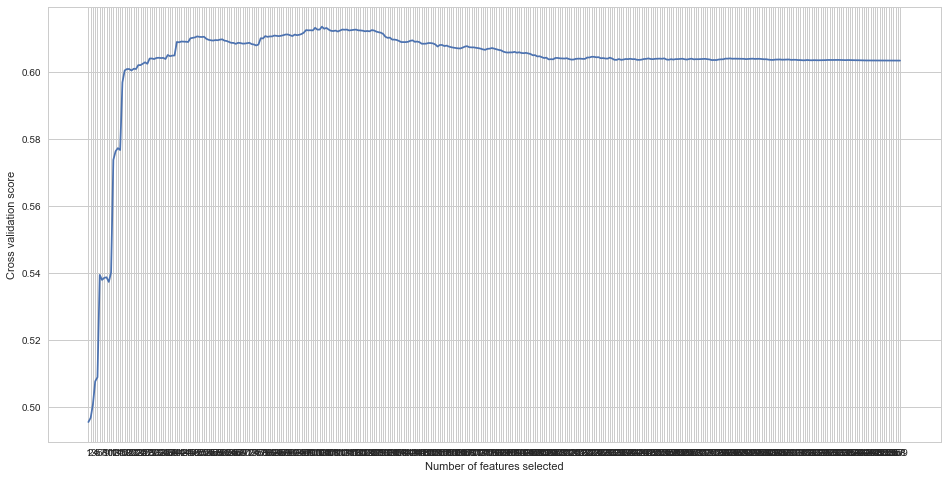


Optimal number of features : 104

(1, 0.49546411502921811)
(2, 0.49673688321185255)
(3, 0.50079886870339008)
(4, 0.50761682925404517)
(5, 0.50886223451092893)
(6, 0.53940406803789598)
(7, 0.53790421299271118)
(8, 0.53852853013653879)
(9, 0.53868606032283817)
(10, 0.5373072317308254)
(11, 0.54014523066205411)
(12, 0.57375229601936772)
(13, 0.57633954475533999)
(14, 0.57725931010161979)
(15, 0.57668842611523263)
(16, 0.59687893893075272)
(17, 0.60045813834747186)
(18, 0.60087367187854956)
(19, 0.60087414784958437)
(20, 0.60045730539816056)


In [15]:
# plot RFECV result
plt.clf()

# Set figure width and height
fig_width = 16 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.xticks(range(1, len(selector.grid_scores_) + 1))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.yticks(np.arange(0.5,0.61,0.02))
plt.show()

print("\nOptimal number of features : %d\n" % selector.n_features_)

for i in range(20):
    print(list(zip(range(1, len(selector.grid_scores_) + 1),selector.grid_scores_))[i])

In [ ]:
### show the selected variables of RFECV
selection = list(zip(selector.ranking_, selector.support_, X_standardized_train.columns))
selection.sort()
for i in selection[:20]:
    print(i)

### variable list from RFECV 
selected_val0 = X_standardized_train.columns[selector.support_]
print(selected_val0)

In [19]:
# further reduce by RFE
X_standardized_train1 = X_standardized_train[X_standardized_train.columns[selector.support_]]

selector1 = RFE(estimator, n_features_to_select=17, step=1)
selector1 = selector1.fit(X_standardized_train1, y_train)

selection1 = list(zip(selector1.ranking_, selector1.support_, X_standardized_train1.columns))
selection1.sort()
for i in selection1[:20]:
    print(i)

selected_val1 = X_standardized_train1.columns[selector1.support_]
print(selected_val1)

(1, True, 'DW1')
(1, True, 'DW3')
(1, True, 'DW4')
(1, True, 'DW5')
(1, True, 'ETH1')
(1, True, 'ETHC1')
(1, True, 'ETHC2')
(1, True, 'ETHC3')
(1, True, 'HU3')
(1, True, 'HU4')
(1, True, 'HUPA1')
(1, True, 'HUPA2')
(1, True, 'HUPA3')
(1, True, 'MC2')
(1, True, 'RFA_2F')
(1, True, 'RHP1')
(1, True, 'RHP2')
(2, False, 'POP90C1')
(3, False, 'POP90C3')
(4, False, 'POP90C2')
Index(['ETH1', 'DW1', 'DW3', 'DW4', 'DW5', 'HU3', 'HU4', 'ETHC1', 'ETHC2',
       'ETHC3', 'RHP1', 'RHP2', 'HUPA1', 'HUPA2', 'HUPA3', 'MC2', 'RFA_2F'],
      dtype='object')


In [201]:
### clean dataset for modeling 

#selected_val = selected_val0
selected_val = list(selected_val1)
#selected_val = ['NOEXCH', 'POP902', 'POP903', 'ETH10', 'ETH16', 'HU4', 'HHD8', 'RHP4','IC13', 'TPE3', 'HC21', 'CARDGIFT']
selected_val.append('CARDGIFT')

selected_val.remove('DW1')
selected_val.remove('DW5')
selected_val.remove('DW4')
selected_val.remove('ETH1')
selected_val.remove('RHP2')
selected_val.remove('HU3')
selected_val.remove('HUPA1')
selected_val.remove('HUPA2')
selected_val.remove('ETHC1')
selected_val.remove('HU4')
selected_val.remove('HUPA3')

# adjust if necessary
#selected_val = ['HHD1', 'CARDGIFT', 'MINRAMNT', 'TIMELAG','CHILD03_B', 'STATE_OH']

X_train_new,X_test_new = X_train[selected_val],X_test[selected_val] # using the non-standardized data
X_standardized_train_new = X_standardized_train[selected_val]

print('\nX_train_new size: %s' % str(X_train_new.shape))
print('X_test_new size: %s' % str(X_test_new.shape))
print('X_standardized_train_new size: %s' % str(X_standardized_train_new.shape))


X_train_new size: (76329, 7)
X_test_new size: (19083, 7)
X_standardized_train_new size: (76329, 7)


In [213]:
# create model
estimator.fit(X_train_new,y_train)
#estimator.fit(X_standardized_train_new,y_train)

# print the intercept and coefficients
coeff_df = pd.DataFrame(np.transpose(np.append(estimator.intercept_, estimator.coef_))
                        ,['Intercept',]+list(X_train_new.columns)
                        ,columns=['Coefficient'])

coeff_df

,Coefficient
Intercept,-0.990087
DW3,-0.005636
ETHC2,0.001538
ETHC3,0.006570
RHP1,0.008010
MC2,-0.005853
RFA_2F,0.240414
CARDGIFT,0.033236


In [277]:
print(coeff_df)

           Coefficient
Intercept    -0.990087
DW3          -0.005636
ETHC2         0.001538
ETHC3         0.006570
RHP1          0.008010
MC2          -0.005853
RFA_2F        0.240414
CARDGIFT      0.033236


In [275]:
# the order of variables by importance
print('Variable importance')
abs(np.std(X_train_new, 0)*estimator.coef_[0]).sort_values(ascending=False)

Variable importance


RFA_2F      0.257895
CARDGIFT    0.150445
MC2         0.094017
RHP1        0.086395
ETHC3       0.080984
DW3         0.030426
ETHC2       0.022403
dtype: float64

Training Set Accuracy 0.618297108569
Training Set Area Under the ROC 0.607437245743


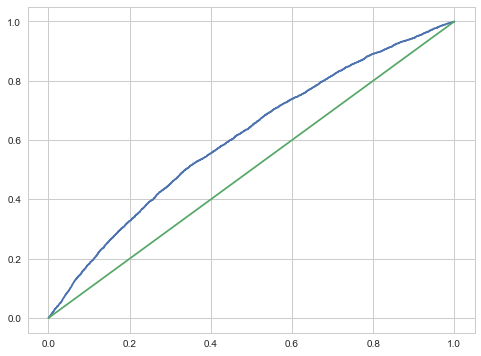

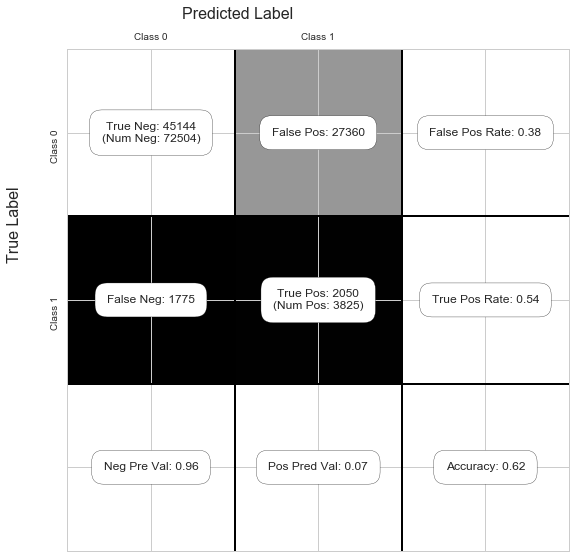

             precision    recall  f1-score   support

          0       0.96      0.62      0.76     72504
          1       0.07      0.54      0.12      3825

avg / total       0.92      0.62      0.72     76329



,decile,size,resp,resp %,cum. resp,cum. resp %
0,1,7633,679,17.75,679,17.75
1,2,7633,543,14.20,1222,31.95
2,3,7633,473,12.37,1695,44.31
3,4,7633,405,10.59,2100,54.90
4,5,7633,345,9.02,2445,63.92
5,6,7632,361,9.44,2806,73.36
6,7,7633,307,8.03,3113,81.39
7,8,7633,286,7.48,3399,88.86
8,9,7633,209,5.46,3608,94.33
9,10,7633,217,5.67,3825,100.00


In [216]:
# check the performance on the training set
predicted_t = estimator.predict(X_train_new)
probs_t = estimator.predict_proba(X_train_new)

print('Training Set Accuracy',metrics.accuracy_score(y_train, predicted_t))
print('Training Set Area Under the ROC',metrics.roc_auc_score(y_train, probs_t[:, 1]))

### Set figure width and height
fig_width = 8 # width
fig_height = 6 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

fpr, tpr, thresholds = metrics.roc_curve(y_train, probs_t[:, 1], pos_label=1)
plt.plot(fpr, tpr, label='Train')
plt.plot([0, 1], [0, 1], '-')
plt.show()

show_confusion_matrix(metrics.confusion_matrix(y_train, predicted_t), ['Class 0', 'Class 1'])

print(metrics.classification_report(y_train, predicted_t))

performance_by_decile(y_train, probs_t[:, 1])

In [205]:
# VIF using training set

vif_cal(X_train_new).sort_values(by='VIF',axis=0, ascending=False)

,Variable,VIF
3,RHP1,1.46
1,ETHC2,1.27
4,MC2,1.24
6,CARDGIFT,1.12
5,RFA_2F,1.11
2,ETHC3,1.08
0,DW3,1.03


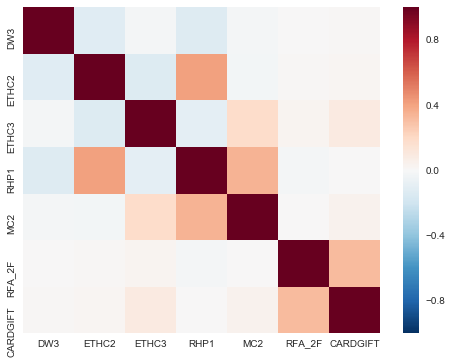

In [274]:
# plot the variable correlation on training set
sns.heatmap(X_train_new.corr())
plt.show()

In [276]:
# variable profiling on training set
fnl_train_data = pd.concat([X_train_new, pd.DataFrame(y_train, columns=[y_col])], axis=1)

# check the variable correlation on training set
print('Variable correlation matrix')
fnl_train_data.corr()

Variable correlation matrix


,DW3,ETHC2,ETHC3,RHP1,MC2,RFA_2F,CARDGIFT,TARGET_B
DW3,1.000000,-0.123510,-0.022304,-0.131562,-0.022876,0.003959,0.013234,-0.007879
ETHC2,-0.123510,1.000000,-0.139546,0.409636,-0.027714,0.014595,0.020140,0.011898
ETHC3,-0.022304,-0.139546,1.000000,-0.096236,0.186468,0.031100,0.091574,0.014562
RHP1,-0.131562,0.409636,-0.096236,1.000000,0.345382,-0.021369,0.000602,0.009644
MC2,-0.022876,-0.027714,0.186468,0.345382,1.000000,0.006945,0.044387,-0.009221
RFA_2F,0.003959,0.014595,0.031100,-0.021369,0.006945,1.000000,0.319032,0.071681
CARDGIFT,0.013234,0.020140,0.091574,0.000602,0.044387,0.319032,1.000000,0.054497
TARGET_B,-0.007879,0.011898,0.014562,0.009644,-0.009221,0.071681,0.054497,1.000000


In [208]:
# check the partial correlation

pc = partial_corr(fnl_train_data)
pd.DataFrame(pc, columns =fnl_train_data.columns, index=fnl_train_data.columns )


,DW3,ETHC2,ETHC3,RHP1,MC2,RFA_2F,CARDGIFT,TARGET_B
DW3,1.000000,-0.005896,0.009167,0.018223,0.071248,0.055175,0.028503,-0.004983
ETHC2,-0.005896,1.000000,0.016126,0.714384,-0.110502,0.111451,0.047197,0.005788
ETHC3,0.009167,0.016126,1.000000,0.001061,0.294125,0.070539,0.096015,0.016590
RHP1,0.018223,0.714384,0.001061,1.000000,0.610642,0.110247,0.016807,0.018623
MC2,0.071248,-0.110502,0.294125,0.610642,1.000000,0.064623,0.040499,-0.017177
RFA_2F,0.055175,0.111451,0.070539,0.110247,0.064623,1.000000,0.335636,0.060599
CARDGIFT,0.028503,0.047197,0.096015,0.016807,0.040499,0.335636,1.000000,0.032984
TARGET_B,-0.004983,0.005788,0.016590,0.018623,-0.017177,0.060599,0.032984,1.000000


Testing Set Accuracy 0.619818686789
Testing Set Area Under the ROC 0.600936179492


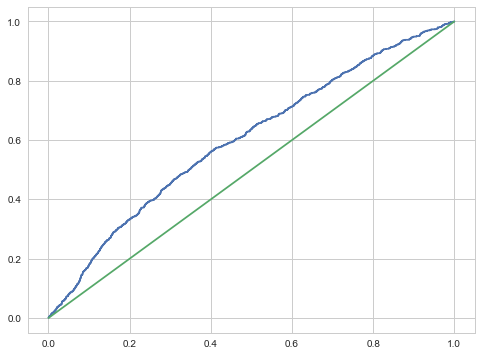

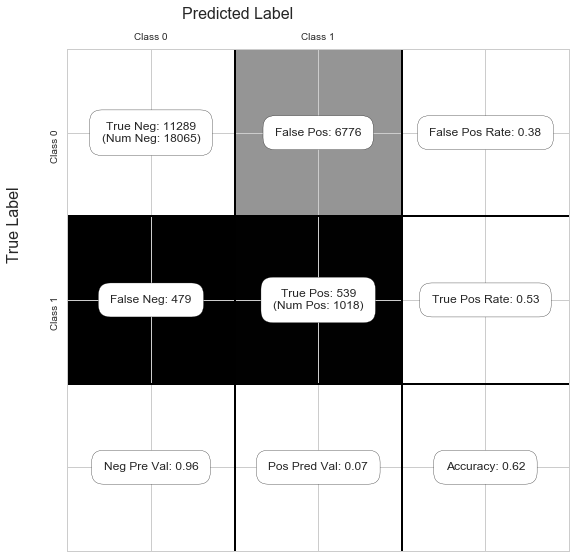

             precision    recall  f1-score   support

          0       0.96      0.62      0.76     18065
          1       0.07      0.53      0.13      1018

avg / total       0.91      0.62      0.72     19083



,decile,size,resp,resp %,cum. resp,cum. resp %
0,1,1909,172,16.90,172,16.90
1,2,1908,158,15.52,330,32.42
2,3,1908,123,12.08,453,44.50
3,4,1908,105,10.31,558,54.81
4,5,1909,82,8.06,640,62.87
5,6,1908,82,8.06,722,70.92
6,7,1908,90,8.84,812,79.76
7,8,1908,83,8.15,895,87.92
8,9,1908,69,6.78,964,94.70
9,10,1909,54,5.30,1018,100.00


In [217]:
# check the performance on the testing set
predicted_v = estimator.predict(X_test_new)
probs_v = estimator.predict_proba(X_test_new)

print('Testing Set Accuracy',metrics.accuracy_score(y_test, predicted_v))
print('Testing Set Area Under the ROC',metrics.roc_auc_score(y_test, probs_v[:, 1]))

### Set figure width and height
fig_width = 8 # width
fig_height = 6 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_v[:, 1], pos_label=1)
plt.plot(fpr, tpr, label='Test')
plt.plot([0, 1], [0, 1], '-')
plt.show()

show_confusion_matrix(metrics.confusion_matrix(y_test, predicted_v), ['Class 0', 'Class 1'])

print(metrics.classification_report(y_test, predicted_v))

performance_by_decile(y_test, probs_v[:, 1])



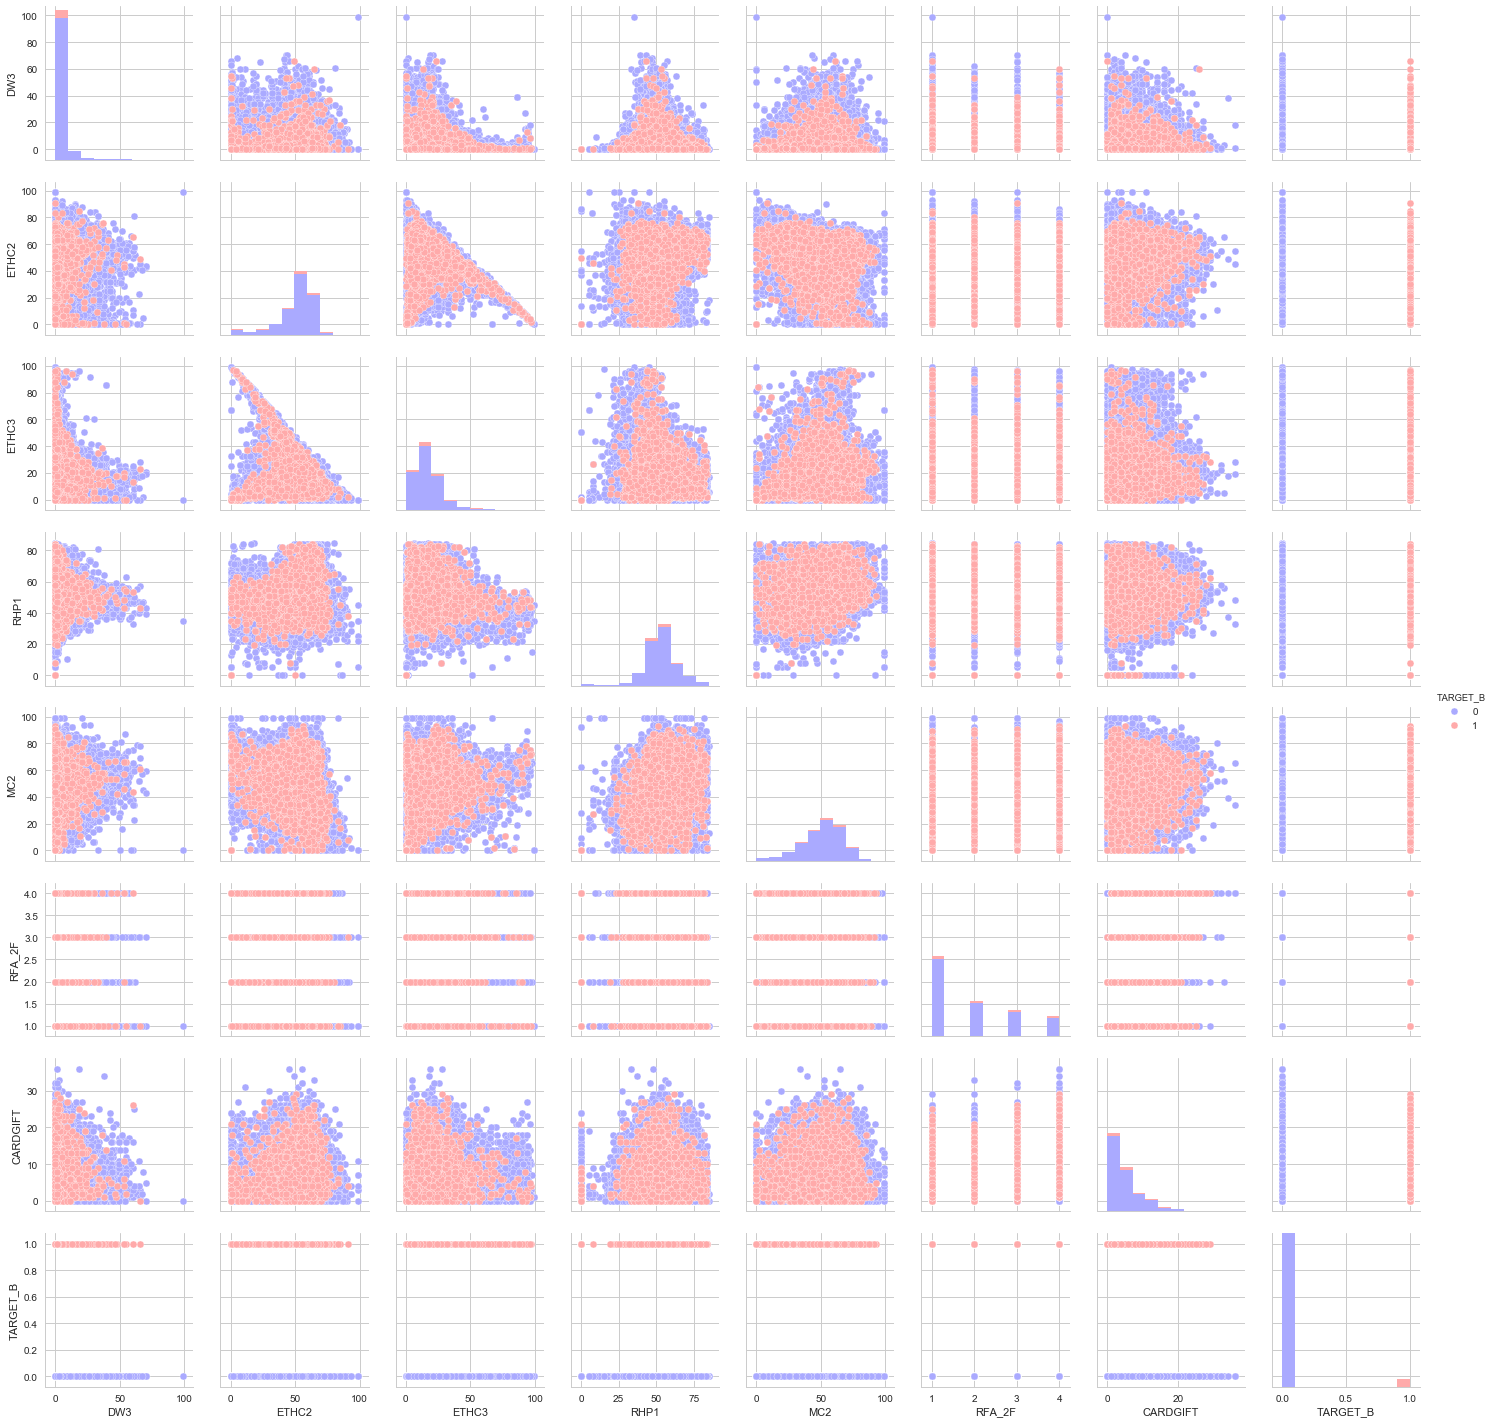

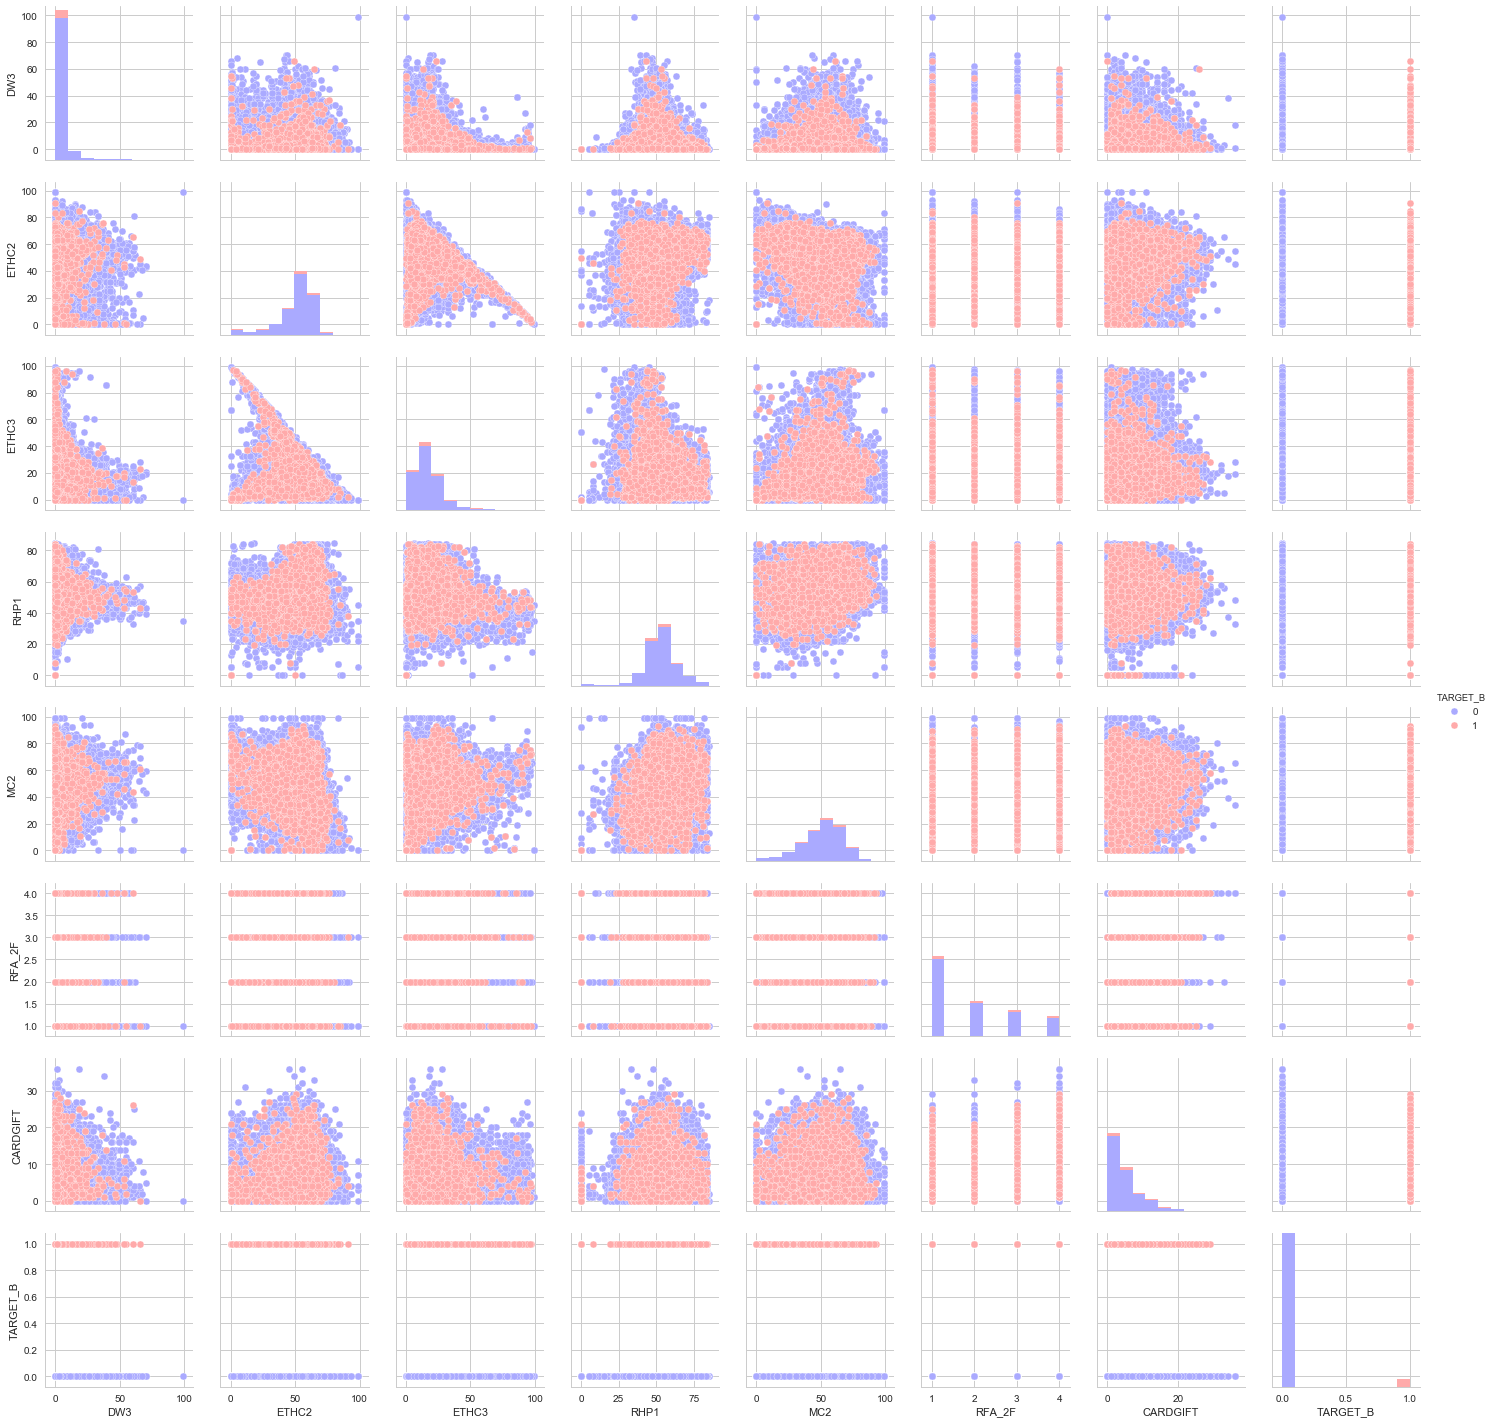

In [219]:
sns.pairplot(fnl_train_data,hue=y_col,palette='bwr')
plt.show()

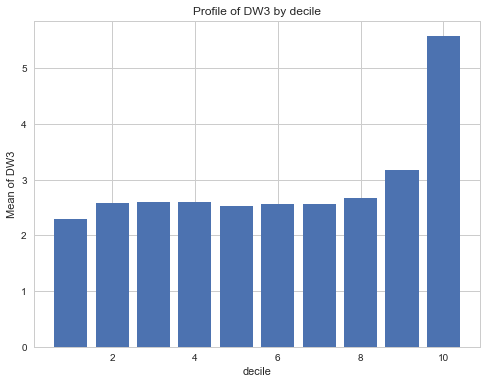

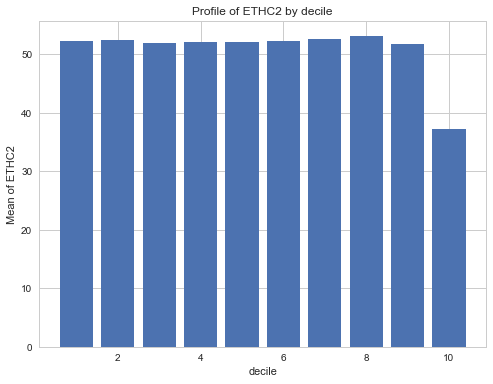

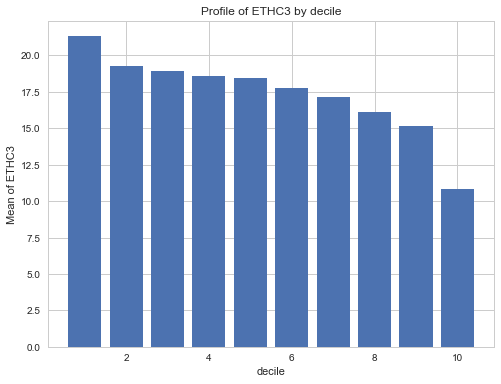

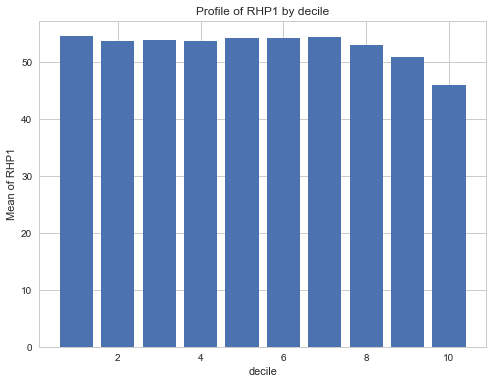

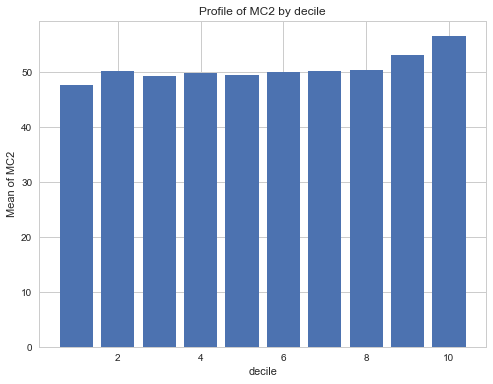

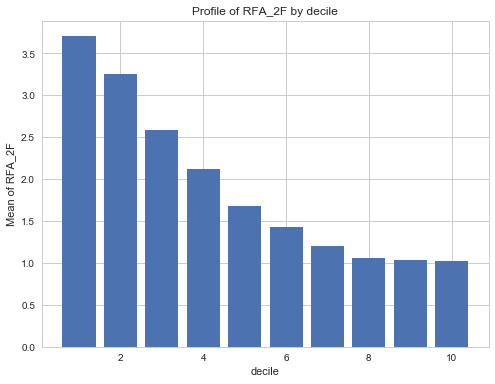

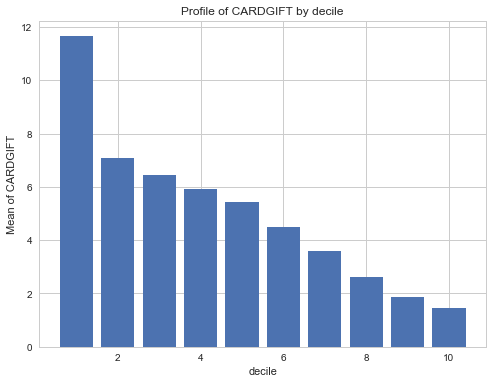

,decile,DW3,ETHC2,ETHC3,RHP1,MC2,RFA_2F,CARDGIFT
0,1,2.287043,52.294904,21.316913,54.599764,47.744137,3.706537,11.655312
1,2,2.574348,52.481855,19.289925,53.676536,50.237914,3.260841,7.092100
2,3,2.598978,51.916678,18.947727,53.945500,49.408620,2.586270,6.450282
3,4,2.606446,52.153806,18.560854,53.775580,49.913402,2.122363,5.933316
4,5,2.526530,52.032622,18.467313,54.206079,49.541596,1.683873,5.442945
5,6,2.563548,52.164046,17.730346,54.309617,50.016116,1.429507,4.505110
6,7,2.566226,52.583519,17.129962,54.511463,50.279051,1.198087,3.584305
7,8,2.668282,53.068125,16.145159,53.057513,50.380322,1.063540,2.634089
8,9,3.167824,51.687279,15.131403,50.976287,53.214726,1.034980,1.861260
9,10,5.576444,37.132058,10.830080,46.086467,56.573038,1.021093,1.439801


In [285]:
# Variable profiling by decile

profiling_by_decile(X_train_new, probs_t[:, 1])   